<a href="https://colab.research.google.com/github/cahcharm/Neuro-and-Complexity-Science/blob/CSHA2021/project/project_spiking_circuit_model_for_working_memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Spiking circuit model for working memory**

Building up a spiking circuit model for working memory (Misha, Science, 2008). 

* Step 1: build LIF neuron, voltage jump synapse, STP synapse
*	Step 2: consider the connectivity used in the paper, build up the network model
*	Step 3: try to encode one item in the model (Fig. 2)
*	Step 4: try to encode two items in the network (Fig. 3)


In [ ]:
pip install brainpy-simulator

     |████████████████████████████████| 126 kB 7.0 MB/s 
  Created wheel for brainpy-simulator: filename=brainpy_simulator-1.0.2-py3-none-any.whl size=152104 sha256=772e77d61b9878f167d08ab9536cdd9baa345357a4a14efe17f5e3b4693bb847
  Stored in directory: /root/.cache/pip/wheels/ec/1c/3f/e33093b69bc03ff9b2742480ec6126ddef875ba4f6d3699659
Successfully built brainpy-simulator


In [ ]:
import numpy as np
import brainpy as bp

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## Step 1: build LIF neuron, voltage jump synapse, STP synapse

**Spiking network: LIF Neuron**

---

The network is composed of $N_E$ excitatory and $N_I$ inhibitory current-based integrate-and-fire neurons, whose sub-threshold depolarization dynamics is described by
$$
\tau_m \frac{dV_i}{dt} = - V_i + I_i^{(rec)}(t)+I_{i}^{(ext)}(t)
$$
where $i = 1,\cdots,(N_E+N_I)$ refere to the neuron number, $\tau_m$ is the membrane time constant, $I_i^{(rec)}(t)$ is the current mediated by recurrent synaptic connections, and $I_i^{(ext)}(t)$ is the external current provided by distant brain areas. Membrane resistance is absorbed into the definition of the currents.

When the depolarization hits a fixed threshold $\theta(V_i(t)\geq \theta)$， the neuron emits a spike and becomes refractory for a period $\tau_{arp}$ with a sub-threshold potential $V_r$

---

External current are modeld as Gaussian white noise
$$
I_i^{(ext)}(t) = \mu_{ext} + \sigma_{ext}\cdot \eta_i(t)
$$
with $\langle\eta_i(t)\rangle = 0, \langle \eta_i(t)\eta_j(t')\rangle = \delta_{ij}\delta(t-t')$, so that $\mu_{ext}$ and $\sigma_{ext}^2$ are respectively the mean and the variance of the external currents.

---

The recurrent current $I_i^{(rec)}(t)$ is the sum of the postsynaptic currents from all other neurons in the network targeting the neuron i,
$$
I_i{(rec)}(t) = \sum_j\hat{J}_{ij}(t)\sum_{k}\delta(t-t_k^{(j)}-D_{ij})
$$
where $\hat{J}_{ij}(t)$ is the instantaneous efficacy (time dependence is due to short-term synaptic dynamics) of the synapse connecting neuron $j$ to neuron $i$; the sum on $k$ is over all the emission times, $t_{k}^{(j)}$, of presynaptic neuron $j$; $D_{ij}$ is the transmission delay uniformly distributed between 1 and 5 ms. For simplicity, we neglect rise and decay times of the postsynaptic currents.

Excitatory-to-excitatory synapses display short-term plasticity is
$$
\frac{du_j(t)}{dt} = \frac{U - u_j(t)}{\tau_F} + U[1-u_j(t)]\sum_k\delta(t-t_k^{(j)})\\
\frac{dx_j(t)}{dt}=\frac{1-x_j(t)}{\tau_D} - u_j(t)x_j(t)\sum_{k}\delta(t-t_k^{(j)})
$$
where the functions multiplying the spike train are evaluated inmmediately before the dleta functions,i.e. at $t_k^{(j)-}$. The $\hat{J}_{ij}(t)$ is given by
$$
\hat{J}_{ij}(t)=J_{ij}\cdot u_j(t-D_{ij})\cdot x_j(t-D_{ij})
$$
where $J_{ij}$ is the absolute synaptic efficacy. The remaining synaptic populations, inhibitory and excitatory-inhibitorym exhibit linear synaptic transmission, i.e., $\hat{J}_{ij}(t)=J_{ij}$. The dynamics of the network is completely described by the coupled system of above non-linear equations combined with the conditions for spike emission and refractoriness described above. These equations are integrated using an Euler scheme.

Some of the above parameters are different between excitatory and inhibitory cells. 

In [ ]:
class LIF(bp.NeuGroup):
  target_backend = ['numpy', 'numba']

  @staticmethod
  @bp.odeint(method='exponential_euler')
  def integral(V, t, Irec, Iext, tau):
    dvdt = (-V + Irec + Iext) / tau_m
    return dvdt

  def __init__(self, size, cls=1, theta_E=20., theta_I=20., Vr_E=16., Vr_I=13., tau_m_E=15., tau_m_I=10.,
          tau_arp_E=2., tau_arp_I=2., mu_ext_E=23.10, mu_ext_I=21.0, sigma_ext_E=1., sigma_ext_I=1., Jij, tk, u, x **kwargs):
    super(LIF, self).__init__(size=size, **kwargs)
    
    # Single-cell parameters
    self.cls = cls # judge teh cell is excitatory or inhibitory, 0 for inhibitory, 1 for excitatory 
    self.theta_E = theta_E # Spike emission threshold of excitatory cells [mV]
    self.theta_I = theta_I # Spike emission threshold of inhibitory cells [mV]
    self.Vr_E = Vr_E # Reset potential of excitatory cells [mV]
    self.Vr_I = Vr_I # Reset potential of inhibitory cells [mV]
    self.tau_m_E = tau_m_E # Membrane time constant of excitatory cells [ms]
    self.tau_m_I = tau_m_I # Membrane tiem constant of inhibitory cells [ms]
    self.tau_arp_E = tau_arp_E # Absolute refractory period of excitatory cells [ms]
    self.tau_arp_I = tau_arp_I # Absolute refractory period of inhibitory cells [ms]

    self.mu_ext_E = mu_ext_E # Mean external current of excitatory cells [mV]
    self.mu_ext_I = mu_ext_I # Mean external current of inhibitory cells [mV]
    self.sigma_ext_E = sigma_ext_E # Standard deviation of external current of excitatory cells [mV]
    self.sigma_ext_I = sigma_ext_I # Standard deviation of external current of inhibitory cells [mV]
    self.Jij = Jij # 
    self.tj = tj # 

    if self.cls == 1:
      self.theta = self.theta_E
      self.Vr = self.Vr_E
      self.tau_m = self.tau_m_E
      self.tau_arp = self.tau_arp_E
      self.mu_ext = self.mu_ext_E
      self.sigma_ext = self.sigma_ext_E
    elif self.cls == 0:
      self.theta = self.theta_I
      self.Vr = self.Vr_I
      self.tau_m = self.tau_m_I
      self.tau_arp = self.tau_arp_I
      self.mu_ext = self.mu_ext_I
      self.sigma_ext = self.sigma_ext_I

    # variables
    self.t_last_spike = bp.ops.ones(self.num) * -1e7
    self.refractory = bp.ops.zeros(self.num, dtype=bool)
    self.spike = bp.ops.zeros(self.num, dtype=bool)
    self.V = bp.ops.zeros(self.num)
    self.Irec = bp.ops.zeros(self.num) # Irec
    self.Iext = bp.ops.zeros(self.num) # Iext
    
  def update(self, _t):
    
    for i in range(self.num):
      spike = False
      refractory = (_t - self.t_last_spike[i]) <= self.tau_arp
      if not refractory:
        # TODO: calculate Irec
        self.Iext[i] = np.random.normal(self.mu_ext, seld.sigma_ext, size=1)
        V = self.integral(self.V[i], _t, self.Irec[i],
                          self.Iext[i], self.tau_m)
        spike = (V >= self.theta)
        if spike:
          V = self.Vr
          self.t_last_spike[i] = _t
          refractory = True
        self.V[i] = V
      self.spike[i] = spike
      self.refractory[i] = refractory
      self.Irec[i] = 0.
      self.Iext[i] = 0.

In [ ]:
## Network parameters
f =  0.10 # Coding level
p = 5 # Number of memories
c = 0.20 # Probability of synaptic contact
N_E = 8000 # Number of excitatory cells
N_I = 2000 # Number of inhibitory cells

In [ ]:
## Synaptic parameters
J_IE = 0.135 # Synaptic efficacy E to I [mV]
J_EI = 0.25 # Synaptic efficacy I to E [mV]
J_II = 0.20 # Synaptic efficacy I to I [mV]
J_b = 0.10 # Baseline level of E to E synapses [mV]
J_p = 0.45 # Potentiated level of E to E synapses [mV]
gamma_0 = 0.10 # Fraction of potentiated synapses before learning
delta = range(0.1, 1) # Synaptic delays

**Voltage Jump Synapse**

$$
I = \sum_{j\in C} g \delta(t-t_j-D)
$$

where $g$ denotes the chemical synaptic strength, $t_j$ the spiking moment of the presynaptic neuron $j$, $C$ the set of neurons in the encoding layer, and $D$ the transmission delay of chemical synapses. For simplicity, we omit the rise and decay phases of post-synaptic currents. 

In [ ]:
class VoltageJump(bp.TwoEndConn):
  target_backend = ['numpy', 'numba']

  def __init__(self, pre, post, conn, delay=0., post_refractory=False, weight=1., **kwargs):
    # parameters
    self.delay = delay
    self.post_has_refractory = post_refractory

    # connections
    self.conn = conn(pre.size, post.size)
    self.pre_ids, self.post_ids = conn.requires('pre_ids', 'post_ids')
    self.num = len(self.pre_ids)

    # variables
    self.s = np.zeros(self.num)
    self.w = np.ones(self.num) * weight
    self.I_syn = self.register_constant_delay('I_syn', size=self.num, delay_time=delay)

    super(VoltageJump, self).__init__(pre=pre, post=post, **kwargs)
    
    # checking
    assert hasattr(pre, 'V'), 'Pre-synaptic group must has "V" variable.'
    assert hasattr(post, 'V'), 'Post-synaptic group must has "V" variable.'
    assert hasattr(post, 'input'), 'Post-synaptic group must has "input" variable.'
    if post_refractory:
      assert hasattr(post, 'refractory'), 'Post-synaptic group must has "refractory" variable.'

  def update(self, _t):
    for i in range(self.num):
      pre_id = self.pre_ids[i]
      post_id = self.post_ids[i]
      # update
      self.s[i] = self.pre.spike[pre_id]
      self.I_syn.push(i, self.s[i] * self.w[i])
      # output
      I_syn = self.I_syn.pull(i)
      if self.post_has_refractory:
        self.post.V += I_syn * (1. - self.post.refractory[post_id])
      else:
        self.post.V += I_syn

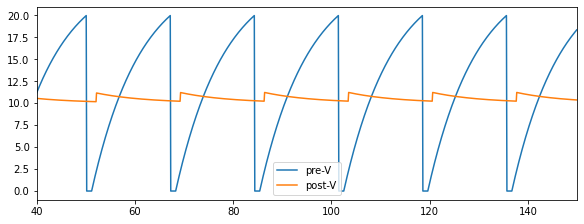

In [ ]:
neu1 = LIF(1, monitors=['V', 'spike'])
neu2 = LIF(1, monitors=['V'])

syn1 = VoltageJump(pre=neu1, post=neu2, conn=bp.connect.All2All(), delay=2.0)

net = bp.Network(neu1, syn1, neu2)
net.run(150., inputs=[(neu1, 'input', 25.), (neu2, 'input', 10.)])

fig, gs = bp.visualize.get_figure(1, 1, 3, 8)
plt.plot(net.ts, neu1.mon.V, label='pre-V')
plt.plot(net.ts, neu2.mon.V, label='post-V')
plt.xlim(40, 150)
plt.legend()


**STP Synapse**

$$\frac{d u}{d t}= -\frac{u}{\tau_{f}}+U\left(1-u^{-}\right) \delta\left(t-t_{s p}\right)$$

$$\frac{d x}{d t}= \frac{1-x}{\tau_{d}}-u^{+} x^{-} \delta\left(t-t_{s p}\right)$$

$$\frac{d I}{d t}= -\frac{I}{\tau_{s}}+A u^{+} x^{-} \delta\left(t-t_{s p}\right)$$

$$u^{+}=u^{-}+U\left(1-u^{-}\right)$$

Or we can see the dynamics as:

$$
\frac {du} {dt} = - \frac u {\tau_f} 
$$

$$
\frac {dx} {dt} =  \frac {1-x} {\tau_d} 
$$

$$
\frac {dI} {dt} = - \frac I {\tau}
$$

$$
\rm{if (pre \ fire), then}
\begin{cases} 
u^+ = u^- + U(1-u^-) \\ 
I^+ = I^- + Au^+x^- \\
x^+ = x^- - u^+x^- 
\end{cases}
$$

In [ ]:
## Short-term synaptic dynamics parameters
U = 0.20 # Baseline utilization factor
tau_F = 1500 # Recovery time of utilization factor [ms]
tau_D = 200 # Recovery time of synaptic resources [ms]

In [ ]:
class STP(bp.TwoEndConn):
  target_backend = 'general'

  @staticmethod
  @bp.odeint(method='exponential_euler')
  def integral(s, u, x, t, tau, tau_d, tau_f):
    # Dynamics
    dsdt = - s / tau 
    dudt = - u / tau_f 
    dxdt = (1 - x) / tau_d
    return dsdt, dudt, dxdt
  
  def __init__(self, pre, post, conn, delay=0., U=0.15, tau_f=1500., tau_d=200., tau=8., A=1.,  **kwargs):
    # parameters
    self.tau_d = tau_d
    self.tau_f = tau_f
    self.tau = tau
    self.U = U
    self.delay = delay

    # connections
    self.conn = conn(pre.size, post.size)
    self.pre_ids, self.post_ids = conn.requires('pre_ids', 'post_ids')
    self.num = len(self.pre_ids)

    # variables
    self.s = bp.ops.zeros(self.num)
    self.x = bp.ops.ones(self.num)
    self.u = bp.ops.zeros(self.num)
    self.A = A
    self.I_syn = self.register_constant_delay('I_syn', size=self.num, delay_time=delay)
    
    super(STP, self).__init__(pre=pre, post=post, **kwargs)

  def update(self, _t):
    for i in range(self.num):
      pre_id, post_id = self.pre_ids[i], self.post_ids[i]

      self.s[i], u, x = self.integral(self.s[i], self.u[i], self.x[i], _t, self.tau, self.tau_d, self.tau_f)
      if self.pre.spike[pre_id]:
        # update if there is a spike
        u += self.U * (1 - self.u[i])
        self.s[i] += self.A * u * self.x[i]  
        x -= u * self.x[i]
      self.u[i] = u
      self.x[i] = x

      # output
      self.I_syn.push(i, self.s[i])
      self.post.input[post_id] += self.I_syn.pull(i)

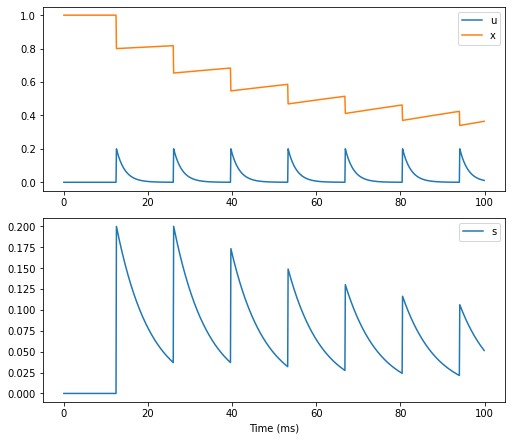

In [ ]:
## STD/STF parameters and plot 
neu1 = LIF(1, monitors=['V'])
neu2 = LIF(1, monitors=['V'])

# STD
syn = STP(U=0.2, tau_d=150., tau_f=2., pre=neu1, post=neu2, 
          conn=bp.connect.All2All(), monitors=['s', 'u', 'x'])
net = bp.Network(neu1, syn, neu2)
net.run(100., inputs=(neu1, 'input', 28.))

# plot
fig, gs = bp.visualize.get_figure(2, 1, 3, 7)

fig.add_subplot(gs[0, 0])
plt.plot(net.ts, syn.mon.u[:, 0], label='u')
plt.plot(net.ts, syn.mon.x[:, 0], label='x')
plt.legend()

fig.add_subplot(gs[1, 0])
plt.plot(net.ts, syn.mon.s[:, 0], label='s')
plt.legend()

plt.xlabel('Time (ms)')
plt.show()

## Step 2: consider the connectivity used in the paper, build up the network model

In [ ]:
dt = 0.0001  # [s]
bp.backend.set(dt=dt)

In [ ]:
# the parameters of network
alpha = 1.5
J_EE = 8.  # the connection strength in each excitatory neural clusters
J_IE = 1.75  # Synaptic efficacy E → I
J_EI = 1.1  # Synaptic efficacy I → E
tau_f = 1.5  # time constant of STF  [s]
tau_d = .3  # time constant of STD  [s]
U = 0.3  # minimum STF value
tau = 0.008  # time constant of firing rate of the excitatory neurons [s]
tau_I = tau  # time constant of firing rate of the inhibitory neurons

Ib = 8.  # background input and external input
Iinh = 0.  # the background input of inhibtory neuron

cluster_num = 16  # the number of the clusters

In [ ]:
# the parameters of external input

stimulus_num = 5
Iext_train = 225  # the strength of the external input
# the time interval between the consequent external input [s]
Ts_interval = 0.070
Ts_duration = 0.030  # the time duration of the external input [s]
duration = 2.500  # [s]

the working memory model based on STP was used to derive the expression for the postsynaptic current resulting from the activity of a large, uncorrelated pre-synaptic population.

The resulting network model has three differential equations for each of $P$ excitatory clusters (synaptic current $h_\mu$ and two STP variables $u_\mu$ and $x_\mu$ for each cluster $\mu; \mu = 1,..., P$) and one additional equation for the inhibitory pool current $h_I$:

$$
\begin{gathered}
\tau \frac{d h_{\mu}}{d t}=-h_{\mu}+J_{E E} u_{\mu} x_{\mu} R_{\mu}-J_{E l} R_{l}+I_{b}+I_{e}(t) \\
\frac{d u_{\mu}}{d t}=\frac{U-u_{\mu}}{\tau_{f}}+U\left(1-u_{\mu}\right) R_{\mu} \\
\frac{d x_{\mu}}{d t}=\frac{1-x_{\mu}}{\tau_{d}}-u_{\mu} x_{\mu} R_{\mu}, \text { and } \\
\tau \frac{d h_{I}}{d t}=-h_{I}+J_{I E} \sum_{\nu} R_{\nu}
\end{gathered}
$$

where $t$ is the neuronal time constant, for simplicity the same for excitation and inhibition; $I_b$ is the constant background excitation; and $I_e$ is the external input used to load memory items into the network. 

$$
R(h)=\alpha \ln (1+\exp (h / \alpha))
$$

is neuronal gain chosen in the form of a smoothed threshold-linear function, also the same for excitatory and inhibitory neurons. 

In [ ]:
# the excitatory cluster model and the inhibitory pool model

class WorkingMemoryModel(bp.NeuGroup):
  target_backend = ['numpy', 'numba']

  def __init__(self, size, **kwargs):
    self.inh_h = 0.
    self.inh_r = self.log(self.inh_h)
    self.u = bp.ops.ones(cluster_num) * U
    self.x = bp.ops.ones(cluster_num)
    self.h = bp.ops.zeros(cluster_num)
    self.r = self.log(self.h)
    self.input = bp.ops.zeros(cluster_num)

    super(WorkingMemoryModel, self).__init__(size, **kwargs)

  @staticmethod
  @bp.odeint
  def int_exc(u, x, h, t, r, r_inh, Iext):
    du = (U - u) / tau_f + U * (1 - u) * r
    dx = (1 - x) / tau_d - u * x * r
    dh = (-h + J_EE * u * x * r - J_EI * r_inh + Iext + Ib) / tau
    return du, dx, dh

  @staticmethod
  @bp.odeint
  def int_inh(h, t, r_exc):
    h_I = (-h + J_IE * np.sum(r_exc) + Iinh) / tau_I
    return h_I

  @staticmethod
  def log(h):
    return alpha * np.log(1. + np.exp(h / alpha))

  def update(self, _t):
    self.u, self.x, self.h = self.int_exc(
        self.u, self.x, self.h, _t, self.r, self.inh_r, self.input)
    self.r = self.log(self.h)
    self.inh_h = self.int_inh(self.inh_h, _t, self.r)
    self.inh_r = self.log(self.inh_h)
    self.input[:] = 0.

In [ ]:
# the external input

I_inputs = np.zeros((int(duration / dt), cluster_num))
for i in range(stimulus_num):
    t_start = (Ts_interval + Ts_duration) * i + Ts_interval
    t_end = t_start + Ts_duration
    idx_start, idx_end = int(t_start / dt), int(t_end / dt)
    I_inputs[idx_start: idx_end, i] = Iext_train


# model.monwork running

model = WorkingMemoryModel(cluster_num, monitors=['u', 'x', 'r', 'h'])
model.run(duration, inputs=['input', I_inputs])

In [ ]:
# visualization

colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())

fig, gs = bp.visualize.get_figure(5, 1, 2, 12)
fig.add_subplot(gs[0, 0])
for i in range(stimulus_num):
    plt.plot(model.mon.ts, model.mon.r[:, i], label='Cluster-{}'.format(i))
plt.ylabel("$r (Hz)$")
plt.legend(loc='right')

fig.add_subplot(gs[1, 0])
hist_Jux = J_EE * model.mon.u * model.mon.x
for i in range(stimulus_num):
    plt.plot(model.mon.ts, hist_Jux[:, i])
plt.ylabel("$J_{EE}ux$")

fig.add_subplot(gs[2, 0])
for i in range(stimulus_num):
    plt.plot(model.mon.ts, model.mon.u[:, i], colors[i])
plt.ylabel('u')

fig.add_subplot(gs[3, 0])
for i in range(stimulus_num):
    plt.plot(model.mon.ts, model.mon.x[:, i], colors[i])
plt.ylabel('x')

fig.add_subplot(gs[4, 0])
for i in range(stimulus_num):
    plt.plot(model.mon.ts, model.mon.r[:, i], colors[i])
plt.ylabel('h')
plt.xlabel('time [s]')

plt.show()

## Step 3: try to encode one item in the model (Fig. 2)

## Step 4: try to encode two items in the network (Fig. 3)